In [187]:
import pandas as pd
import numpy as np

In [188]:
data = pd.read_csv('datas/NYADI.csv', parse_dates=True)
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index).normalize()
data

,open,high,low,close,volume
date,,,,,
2021-11-29,282.3,310.5,282.3,310.50,194.0
2021-11-30,316.7,341.5,316.7,341.50,171.0
2021-12-01,348.3,375.6,348.3,375.60,150.0
2021-12-02,375.6,413.1,375.6,413.10,390.0
2021-12-05,421.3,454.4,421.3,454.40,1533.0
...,...,...,...,...,...
2025-06-16,438.0,448.8,436.1,437.95,48369.0
2025-06-17,437.0,442.0,433.9,439.20,5919.0
2025-06-18,447.0,447.5,431.0,435.75,23112.0


In [189]:
# filter to select the returns which are like double and find the floorsheet patters
lookahead_days = 30
threshold = 1.5

# lets find the doubling points
double_points = []
for i in range(len(data) - lookahead_days):
    prices_now = data['close'].iloc[i]
    future_prices = data['close'].iloc[i+lookahead_days]
    if (future_prices > threshold * prices_now).any():
        double_points.append(i)

data['doubling'] = 0
data.iloc[double_points, data.columns.get_loc('doubling')] = 1
print(np.unique(data['doubling'], return_counts=True))

(array([0, 1]), array([799,  37]))


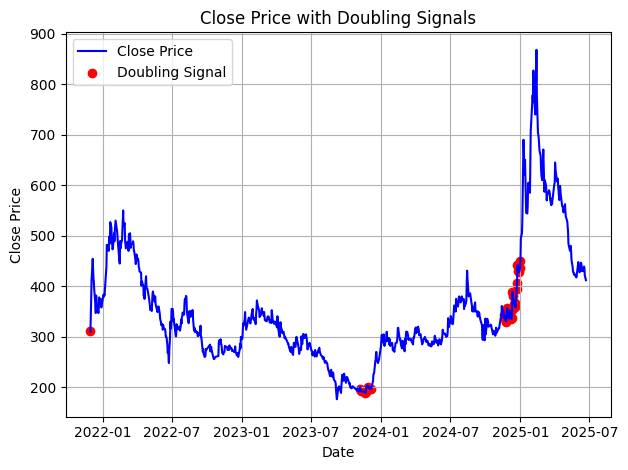

In [190]:
import matplotlib.pyplot as plt

# Plot the closing prices
plt.plot(data.index, data['close'], label='Close Price', color='blue')

# Overlay the doubling points as red dots
doubling_points = data[data['doubling'] == 1]
plt.scatter(doubling_points.index, doubling_points['close'], color='red', label='Doubling Signal', marker='o')

plt.title('Close Price with Doubling Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [191]:
# lets drop the doubling coloumn from the data as we don't require that to fit the scaler
normal_data = data.drop(['doubling'], axis=1)
# lets fit the scaler in the data to use later
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = scaler.fit_transform(normal_data)
data_scaled

array([[-0.61191571, -0.4488006 , -0.56379172, -0.38070644, -0.48209364],
       [-0.30789824, -0.18665608, -0.2462325 , -0.10685363, -0.48256608],
       [-0.02862638,  0.10170289,  0.04547886,  0.19438445, -0.48299744],
       ...,
       [ 0.8436563 ,  0.70970905,  0.80891337,  0.72574724, -0.01133603],
       [ 0.82067824,  0.6834946 ,  0.6436718 ,  0.5963297 ,  0.92068928],
       [ 0.5873625 ,  0.49407404,  0.63351729,  0.51594065, -0.13628666]],
      shape=(836, 5))

In [192]:
# now lets make a sequence of past points before the doubling points

window_size = 30
sequences = []

for idx in double_points:
    if idx - window_size >= 0: # make sure that there is enough past points in the data
        window = data_scaled[idx - window_size:idx] # all ohlcv values here appended
        sequences.append(window)
        
X_train = np.array(sequences)
X_train # (N, seq_size, dim)

array([[[-1.34367869e+00, -1.38744711e+00, -1.43246386e+00,
         -1.42841427e+00, -3.50405578e-01],
        [-1.42763700e+00, -1.40351403e+00, -1.43338700e+00,
         -1.45403276e+00, -4.08639186e-01],
        [-1.42763700e+00, -1.31641440e+00, -1.45738857e+00,
         -1.31710635e+00, -3.51001266e-01],
        ...,
        [-1.42852078e+00, -1.41027905e+00, -1.41677053e+00,
         -1.42753087e+00, -4.65743042e-01],
        [-1.43647472e+00, -1.39844026e+00, -1.43431014e+00,
         -1.37276031e+00, -4.69029595e-01],
        [-1.38875105e+00, -1.36546079e+00, -1.37522935e+00,
         -1.35685918e+00, -4.49721097e-01]],

       [[-1.42763700e+00, -1.40351403e+00, -1.43338700e+00,
         -1.45403276e+00, -4.08639186e-01],
        [-1.42763700e+00, -1.31641440e+00, -1.45738857e+00,
         -1.31710635e+00, -3.51001266e-01],
        [-1.26855810e+00, -1.17265773e+00, -1.26722230e+00,
         -1.13689354e+00, -1.70405186e-01],
        ...,
        [-1.43647472e+00, -1.3984402

# Lets implement the LSTM VAE model on Pytorch

In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [194]:
class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMVAE, self).__init__()
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h_n, _) = self.encoder_lstm(x)
        h_n = h_n.squeeze(0)
        return self.fc_mu(h_n), self.fc_logvar(h_n)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, seq_len):
        h0 = self.decoder_input(z).unsqueeze(0)
        h0 = (h0, h0)  # initial hidden and cell states
        input_seq = torch.zeros(z.size(0), seq_len, h0[0].size(-1)).to(z.device)
        dec_out, _ = self.decoder_lstm(input_seq, h0)
        out = self.output_layer(dec_out)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, x.size(1))
        return recon_x, mu, logvar


Lets create the log function now

In [195]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss
    

In [196]:
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X_train, dtype=torch.float32)
dataset = TensorDataset(X_tensor)

loader = DataLoader(dataset, batch_size = 1, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMVAE(input_dim=X_train.shape[2], hidden_dim = 64, latent_dim = 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")




Epoch 1, Loss: 13.5012
Epoch 2, Loss: 10.7395
Epoch 3, Loss: 10.5365
Epoch 4, Loss: 10.2347
Epoch 5, Loss: 10.1502
Epoch 6, Loss: 9.9595
Epoch 7, Loss: 10.0190
Epoch 8, Loss: 10.2055
Epoch 9, Loss: 10.2694
Epoch 10, Loss: 10.1120
Epoch 11, Loss: 9.6896
Epoch 12, Loss: 9.9648
Epoch 13, Loss: 9.7729
Epoch 14, Loss: 10.0435
Epoch 15, Loss: 9.7360
Epoch 16, Loss: 10.0418
Epoch 17, Loss: 9.2129
Epoch 18, Loss: 9.8705
Epoch 19, Loss: 10.3710
Epoch 20, Loss: 9.8297
Epoch 21, Loss: 7.8057
Epoch 22, Loss: 9.1190
Epoch 23, Loss: 7.3896
Epoch 24, Loss: 8.1924
Epoch 25, Loss: 8.5141
Epoch 26, Loss: 9.2868
Epoch 27, Loss: 8.3596
Epoch 28, Loss: 7.7684
Epoch 29, Loss: 5.6521
Epoch 30, Loss: 8.0931
Epoch 31, Loss: 6.9779
Epoch 32, Loss: 9.3979
Epoch 33, Loss: 9.0528
Epoch 34, Loss: 7.2313
Epoch 35, Loss: 6.7945
Epoch 36, Loss: 5.5156
Epoch 37, Loss: 6.8694
Epoch 38, Loss: 6.3219
Epoch 39, Loss: 8.1605
Epoch 40, Loss: 8.2969
Epoch 41, Loss: 7.1238
Epoch 42, Loss: 7.3310
Epoch 43, Loss: 8.0016
Epoch 44

In [197]:
# Test the model to make sure output is correct

test = torch.tensor(data_scaled[:30])
test = test.unsqueeze(0)


model.eval()  # set to eval mode (disables dropout, batchnorm etc al)

with torch.no_grad():  # no gradient needed for inference
    x_input = torch.tensor(test, dtype=torch.float32).to(device)
    recon, mu, logvar = model(x_input)

    embeddings = mu.cpu().numpy()  # (batch_size, latent_dim)
    print(embeddings)
    
    # Compute reconstruction error per sequence
    recon_error = F.mse_loss(recon, x_input, reduction='none')  # shape: (batch, seq_len, features)
    recon_error_per_seq = recon_error.mean(dim=[1,2])  # average over seq_len and features
    
    print("Reconstruction error per sequence:", recon_error_per_seq.cpu().numpy())


[[-0.04593303 -0.08357242 -1.0531975   0.19407204  0.2764667  -0.64990985
  -0.4722755   0.02999236 -0.10842204 -0.30486152]]
Reconstruction error per sequence: [0.24272664]


/var/folders/54/562w1nvs3bndzw3hrm6tpznc0000gn/T/ipykernel_37654/1785770135.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_input = torch.tensor(test, dtype=torch.float32).to(device)


# Extending this to Multi Stocks and Training the VAE

In [205]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from datetime import datetime, timedelta

data_folder = 'datas'
window_size = 30
lookahead_days = 30
threshold = 1.5
min_years = 2  # Minimum years of data required
min_gap_days = 60  # Minimum days between doubling events to avoid consecutive detections
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_sequences = []      # final list of sequences
stock_labels = []       # to track stock for each sequence
doubled_stocks_info = []  # to store info about stocks that doubled

def filter_consecutive_points(double_points, data, min_gap=60):
    """
    Filter out consecutive doubling points that are too close together.
    Keep only the first point in each cluster of consecutive detections.
    """
    if len(double_points) == 0:
        return []
    
    filtered_points = [double_points[0]]  # Always keep the first point
    
    for point in double_points[1:]:
        # Check if this point is far enough from the last kept point
        last_kept_point = filtered_points[-1]
        days_between = (data.index[point] - data.index[last_kept_point]).days
        
        if days_between >= min_gap:
            filtered_points.append(point)
        # else:
            
            # print('')
            # print(f"    Skipping consecutive point at {data.index[point]} (only {days_between} days after previous)")
    
    return filtered_points

for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        stock_name = file.replace('.csv', '')
        path = os.path.join(data_folder, file)
        try:
            data = pd.read_csv(path, parse_dates=True)
            if 'close' not in data.columns or 'date' not in data.columns:
                continue
            
            data.set_index('date', inplace=True)
            data.index = pd.to_datetime(data.index).normalize()
            data = data[['open', 'high', 'low', 'close', 'volume']].dropna()
            
            # === Filter out stocks with less than 2 years of data ===
            if len(data) == 0:
                continue
                
            date_range = data.index.max() - data.index.min()
            years_of_data = date_range.days / 365.25
            
            if years_of_data < min_years:
                # print(f"Skipping {stock_name}: Only {years_of_data:.1f} years of data (less than {min_years} years)")
                continue
                
            print(f"Processing {stock_name}: {years_of_data:.1f} years of data")
            
            # === Doubling point detection ===
            raw_double_points = []
            
            for i in range(len(data) - lookahead_days):
                prices_now = data['close'].iloc[i]
                future_price = data['close'].iloc[i + lookahead_days]
                if future_price > threshold * prices_now:
                    raw_double_points.append(i)
            
            # Filter out consecutive points
            double_points = filter_consecutive_points(raw_double_points, data, min_gap_days)
            
            print(f"  Raw doubling points: {len(raw_double_points)}, After filtering consecutive: {len(double_points)}")
            
            # Only process stocks that actually doubled (after filtering)
            if len(double_points) > 0:
                # Store doubling information for filtered points only
                for i in double_points:
                    prices_now = data['close'].iloc[i]
                    future_price = data['close'].iloc[i + lookahead_days]
                    
                    doubled_stocks_info.append({
                        'stock_name': stock_name,
                        'doubling_date': data.index[i],
                        'price_at_detection': prices_now,
                        'price_after_lookahead': future_price,
                        'multiplier': future_price / prices_now,
                        'years_of_data': years_of_data,
                        'days_to_target': lookahead_days
                    })
                
                # Add doubling column (not scaled)
                data['doubling'] = 0
                data.iloc[double_points, data.columns.get_loc('doubling')] = 1
                
                # === Scale only OHLCV (not 'doubling') ===
                scaler = StandardScaler()
                scaled_features = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume']])
                
                # === Extract windows ending at doubling points ===
                for idx in double_points:
                    if idx - window_size >= 0:
                        window = scaled_features[idx - window_size:idx]  # shape: (30, 5)
                        all_sequences.append(window)
                        stock_labels.append(stock_name)
            else:
                print(f"  No valid doubling points found for {stock_name}")
                
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

# === Prepare input tensor ===
X_all = np.array(all_sequences)  # shape: (N, 30, 5)
X_tensor = torch.tensor(X_all, dtype=torch.float32).to(device)
print("X_tensor shape:", X_tensor.shape)

# === Save doubled stocks information to CSV ===
def save_doubled_stocks_to_csv():
    if doubled_stocks_info:
        df_doubled = pd.DataFrame(doubled_stocks_info)
        
        # Sort by stock name and doubling date
        df_doubled = df_doubled.sort_values(['stock_name', 'doubling_date'])
        
        # Format the doubling_date for better readability
        df_doubled['doubling_date'] = df_doubled['doubling_date'].dt.strftime('%Y-%m-%d')
        
        # Round numerical values for better readability
        df_doubled['price_at_detection'] = df_doubled['price_at_detection'].round(2)
        df_doubled['price_after_lookahead'] = df_doubled['price_after_lookahead'].round(2)
        df_doubled['multiplier'] = df_doubled['multiplier'].round(3)
        df_doubled['years_of_data'] = df_doubled['years_of_data'].round(1)
        
        # Save to CSV
        output_file = 'doubled_stocks_info.csv'
        df_doubled.to_csv(output_file, index=False)
        # print(f"\nDoubled stocks information saved to '{output_file}'")
        # print(f"Total doubled stocks events (filtered): {len(df_doubled)}")
        # print(f"Unique stocks that doubled: {df_doubled['stock_name'].nunique()}")
        
        # Display summary
        # print("\nSummary:")
        stock_counts = df_doubled['stock_name'].value_counts()
        # print(f"Top 10 stocks with most doubling events (after filtering):")
        # print(stock_counts.head(10))
        
        # Show multiplier statistics
        # print(f"\nMultiplier statistics:")
        # print(f"Average multiplier: {df_doubled['multiplier'].mean():.2f}")
        # print(f"Max multiplier: {df_doubled['multiplier'].max():.2f}")
        # print(f"Min multiplier: {df_doubled['multiplier'].min():.2f}")
        
        return df_doubled
    else:
        print("No doubled stocks found to save.")
        return None

# Call the function to save the CSV
doubled_stocks_df = save_doubled_stocks_to_csv()

# Display first few rows of the results
if doubled_stocks_df is not None:
    print(f"\nFirst 10 rows of doubled stocks data:")
    print(doubled_stocks_df.head(10).to_string(index=False))

Processing UNHPL: 6.0 years of data
  Raw doubling points: 73, After filtering consecutive: 3
Processing NICLBSL: 5.0 years of data
  Raw doubling points: 30, After filtering consecutive: 2
Processing PFL: 13.8 years of data
  Raw doubling points: 88, After filtering consecutive: 11
Processing DORDI: 2.9 years of data
  Raw doubling points: 12, After filtering consecutive: 1
Processing LUK: 4.8 years of data
  Raw doubling points: 0, After filtering consecutive: 0
  No valid doubling points found for LUK
Processing AHL: 2.3 years of data
  Raw doubling points: 3, After filtering consecutive: 1
Processing SJLIC: 13.9 years of data
  Raw doubling points: 55, After filtering consecutive: 6
Processing MDB: 13.9 years of data
  Raw doubling points: 51, After filtering consecutive: 6
Processing JBBL: 13.9 years of data
  Raw doubling points: 41, After filtering consecutive: 2
Processing UNLB: 2.3 years of data
  Raw doubling points: 4, After filtering consecutive: 1
Processing BHDC: 2.9 year

/var/folders/54/562w1nvs3bndzw3hrm6tpznc0000gn/T/ipykernel_37654/1351705107.py:96: RuntimeWarning: divide by zero encountered in scalar divide
  'multiplier': future_price / prices_now,


  Raw doubling points: 31, After filtering consecutive: 7
Processing USLB: 4.8 years of data
  Raw doubling points: 52, After filtering consecutive: 3
Processing MHCL: 2.2 years of data
  Raw doubling points: 30, After filtering consecutive: 1
Processing TPC: 3.6 years of data
  Raw doubling points: 10, After filtering consecutive: 3
Processing SHEL: 4.2 years of data
  Raw doubling points: 19, After filtering consecutive: 2
Processing GILB: 7.4 years of data
  Raw doubling points: 36, After filtering consecutive: 3
Processing NICA: 13.9 years of data
  Raw doubling points: 25, After filtering consecutive: 3
Processing MLBL: 8.4 years of data
  Raw doubling points: 21, After filtering consecutive: 4
Processing ALBSL: 6.3 years of data
  Raw doubling points: 43, After filtering consecutive: 3
Processing RHGCL: 2.8 years of data
  Raw doubling points: 0, After filtering consecutive: 0
  No valid doubling points found for RHGCL
Processing MSLB: 7.8 years of data
  Raw doubling points: 60,

In [199]:
from torch.utils.data import DataLoader, TensorDataset

# X_tensor = torch.tensor(X_train, dtype=torch.float32)
dataset = TensorDataset(X_tensor)

loader = DataLoader(dataset, batch_size = 30, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMVAE(input_dim=X_tensor.shape[2], hidden_dim = 64, latent_dim = 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = vae_loss(recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")




Epoch 1, Loss: 25.6696
Epoch 2, Loss: 23.0207
Epoch 3, Loss: 22.6489
Epoch 4, Loss: 19.3906
Epoch 5, Loss: 16.7077
Epoch 6, Loss: 15.1871
Epoch 7, Loss: 13.7466
Epoch 8, Loss: 14.5830
Epoch 9, Loss: 13.8287
Epoch 10, Loss: 13.4662
Epoch 11, Loss: 13.6581
Epoch 12, Loss: 13.5982
Epoch 13, Loss: 13.0715
Epoch 14, Loss: 12.9568
Epoch 15, Loss: 13.0291
Epoch 16, Loss: 12.9242
Epoch 17, Loss: 12.9800
Epoch 18, Loss: 12.6428
Epoch 19, Loss: 12.3942
Epoch 20, Loss: 12.1059
Epoch 21, Loss: 11.6443
Epoch 22, Loss: 11.3639
Epoch 23, Loss: 10.9898
Epoch 24, Loss: 10.4250
Epoch 25, Loss: 10.5664
Epoch 26, Loss: 10.3069
Epoch 27, Loss: 10.3743
Epoch 28, Loss: 10.1630
Epoch 29, Loss: 10.4630
Epoch 30, Loss: 10.0864
Epoch 31, Loss: 10.2426
Epoch 32, Loss: 10.2674
Epoch 33, Loss: 10.2729
Epoch 34, Loss: 10.2311
Epoch 35, Loss: 10.1038
Epoch 36, Loss: 10.3075
Epoch 37, Loss: 10.1314
Epoch 38, Loss: 9.9861
Epoch 39, Loss: 10.2775
Epoch 40, Loss: 10.0839
Epoch 41, Loss: 10.2064
Epoch 42, Loss: 9.9623
Epo

In [200]:
model.eval()
recon_errors = []
stock_names = []

with torch.no_grad():
    for i in range(len(X_tensor)):
        x_seq = X_tensor[i:i+1]  # shape (1, 30, 5)
        recon, mu, logvar = model(x_seq)
        
        # Compute MSE per sequence
        error = F.mse_loss(recon, x_seq, reduction='mean').item()
        recon_errors.append(error)
        stock_names.append(stock_labels[i])  # stock for that sequence

# Make a dataframe
import pandas as pd

error_df = pd.DataFrame({
    'stock': stock_names,
    'recon_error': recon_errors
})

# View mean error per stock
print(error_df.groupby('stock')['recon_error'].mean().sort_values(ascending=False))


stock
BNL      1.156992
HDL      0.885249
JSLBB    0.769896
CITY     0.753701
GLH      0.740870
           ...   
NABIL    0.024023
NIFRA    0.017713
BHDC     0.016454
SHL      0.015240
BARUN    0.011005
Name: recon_error, Length: 200, dtype: float64


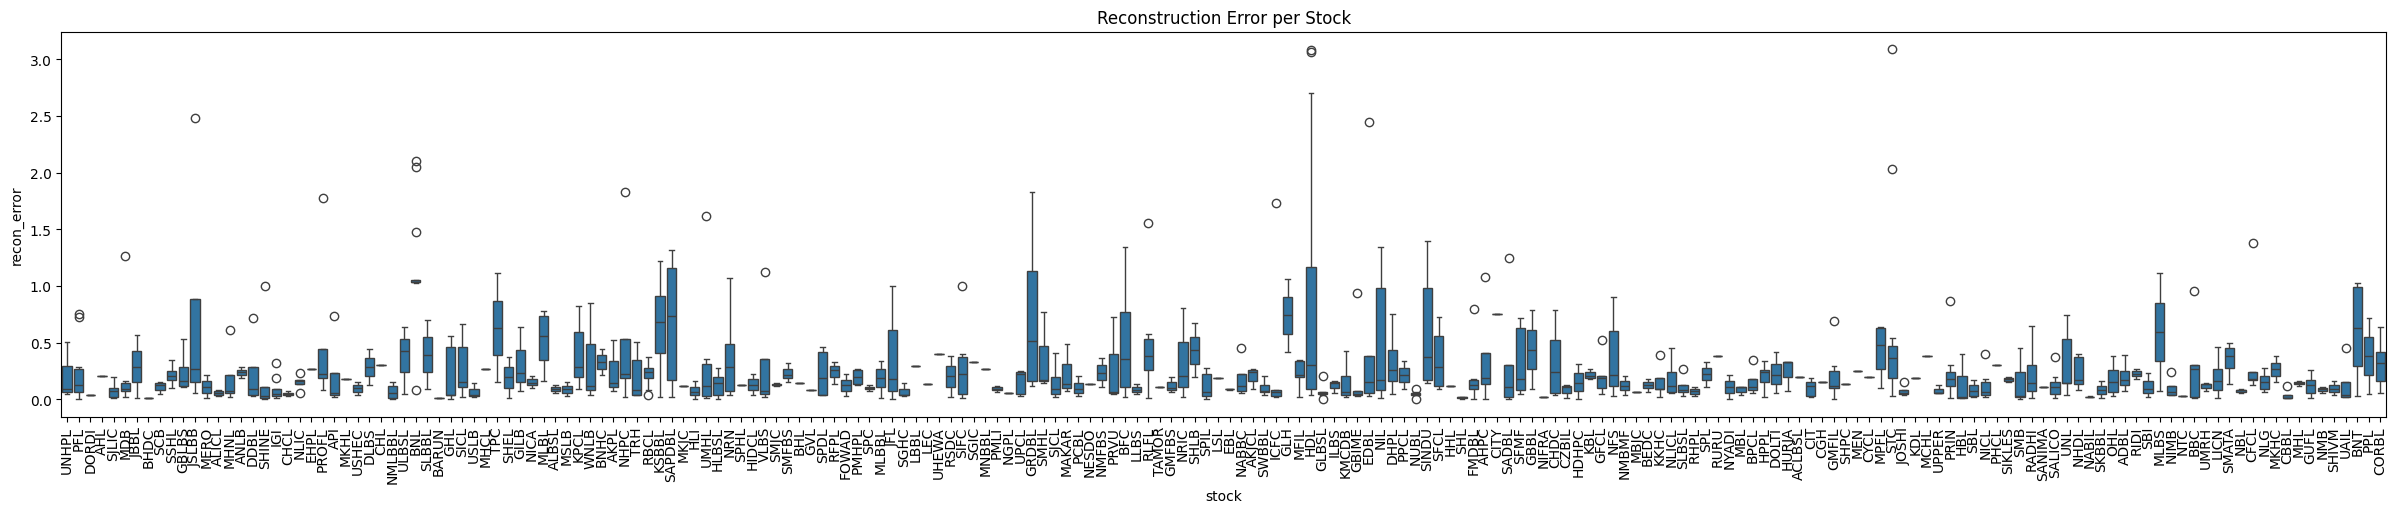

In [201]:
import seaborn as sns
plt.figure(figsize=(30,5))
sns.boxplot(x='stock', y='recon_error', data=error_df)
plt.xticks(rotation=90)
plt.title("Reconstruction Error per Stock")
plt.show()


Total signals: 107
Average future return on low-error signals: 0.0728
Hit rate (positive return): 71.03%


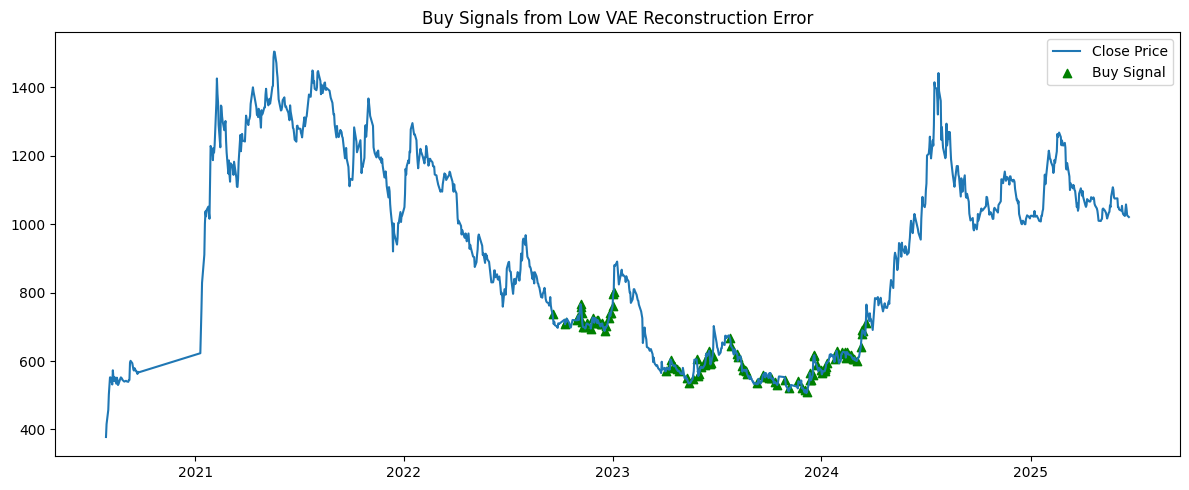

In [202]:

# === Config ===
stock_file = 'datas/ACLBSL.csv'
window_size = 30
lookahead_days = 30  # to evaluate future return
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load and preprocess AHL ===
data = pd.read_csv(stock_file, parse_dates=True)
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index).normalize()
data = data[['open', 'high', 'low', 'close', 'volume']].dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# === Generate windows and compute reconstruction error ===
model.eval()
recon_errors = []
dates = []

with torch.no_grad():
    for i in range(window_size, len(scaled_data)):
        window = scaled_data[i - window_size:i]
        x_seq = torch.tensor(window[np.newaxis, :, :], dtype=torch.float32).to(device)
        recon, mu, logvar = model(x_seq)

        error = F.mse_loss(recon, x_seq, reduction='mean').item()
        recon_errors.append(error)
        dates.append(data.index[i])  # target date is the last day of window

# === Merge errors with price ===
error_df = pd.DataFrame({'date': dates, 'recon_error': recon_errors})
error_df.set_index('date', inplace=True)

data_with_error = data.join(error_df, how='left')

# === Define buy signal: error in bottom 10% ===
threshold = data_with_error['recon_error'].quantile(0.1)
data_with_error['buy_signal'] = (data_with_error['recon_error'] < threshold).astype(int)

# === Evaluate signal ===
data_with_error['future_return'] = data_with_error['close'].shift(-lookahead_days) / data_with_error['close'] - 1

# === Results ===
buy_returns = data_with_error[data_with_error['buy_signal'] == 1]['future_return']
print(f"Total signals: {len(buy_returns)}")
print(f"Average future return on low-error signals: {buy_returns.mean():.4f}")
print(f"Hit rate (positive return): {(buy_returns > 0).mean():.2%}")

# === Visualization ===
plt.figure(figsize=(12, 5))
plt.plot(data_with_error.index, data_with_error['close'], label='Close Price')
plt.scatter(data_with_error[data_with_error['buy_signal'] == 1].index,
            data_with_error[data_with_error['buy_signal'] == 1]['close'],
            color='green', marker='^', label='Buy Signal')
plt.title("Buy Signals from Low VAE Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()


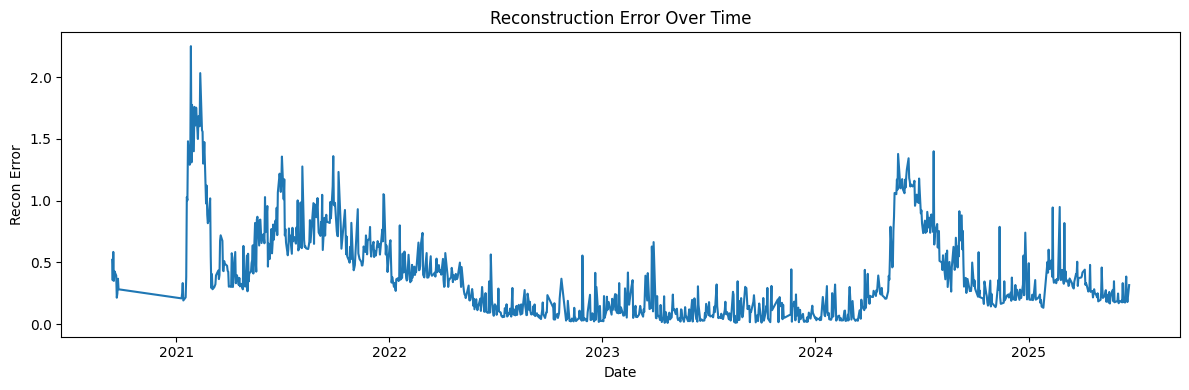

In [203]:
plt.figure(figsize=(12, 4))
plt.plot(data_with_error.index, data_with_error['recon_error'])
plt.title("Reconstruction Error Over Time")
plt.xlabel("Date")
plt.ylabel("Recon Error")
plt.tight_layout()
plt.show()